In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers.Symbol.tolist()
start_date = '2005-01-01'
end_data = '2023-12-31'
ticker = 'AAPL'
df = yf.download(tickers, start=start_date, end=end_data)
df = df.stack().reset_index(level=1)
df = df[df['Ticker'] == ticker]
df = df.head(200)

[*********************100%%**********************]  504 of 504 completed

3 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
/var/folders/6r/ss5r1v153zs2x7pfxs5lfmsr0000gn/T/ipykernel_2920/1239599468.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index(level=1)


Epoch 1/10
Average Loss: 0.4496
Epoch 2/10
Average Loss: 0.0113
Epoch 3/10
Average Loss: 0.0105
Epoch 4/10
Average Loss: 0.0109
Epoch 5/10
Average Loss: 0.0104
Epoch 6/10
Average Loss: 0.0112
Epoch 7/10
Average Loss: 0.0109
Epoch 8/10
Average Loss: 0.0105
Epoch 9/10
Average Loss: 0.0069
Epoch 10/10
Average Loss: 0.0059


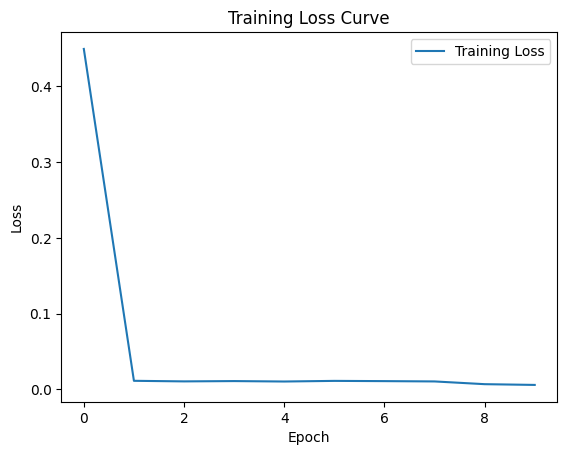

In [2]:
# Loading data^
data = df
# Define Transformer Model^
class StockPricePredictionModel(nn.Module):
    #num_layers =3^
    #hidden_size=128^
    #dropout=0.5^
    def __init__(self, input_size, output_size, num_layers = 5, hidden_size = 256, dropout = 0.7):
        super(StockPricePredictionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

# Define Stock Price Dataset^
class StockPriceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        text = f"{item['Adj Close']} {item['Volume']} {item['Close']} {item['High']} {item['Low']} {item['Open']}"
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['Adj Close'], dtype=torch.float32)
        }
        
# Load dataset and model^
# MODEL^
# TOKENIZER^
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
MODEL = StockPricePredictionModel(input_size=768, output_size=1)

# Sort the data by time^
# SORTED_DATAA^
SORTED_DATAA = data.sort_values(by='Date')

# Set the ratio for dataset^
# TRAINING_RATIO^
# Training dataset 60%
# Testing dataset 40%
TRAINING_RATIO = 0.6

# Indices^
# TRAINING_SIZE^
# TRAINING_INDICES^
# TESTING_INDICES^
TRAINING_SIZE = int(TRAINING_RATIO * len(SORTED_DATAA))
TRAINING_INDICES = np.arange(TRAINING_SIZE)
TESTING_INDICES = np.arange(TRAINING_SIZE, len(SORTED_DATAA))

# Spliting the dataset^
# TRAINING_DATA^
# TESTING_DATA^
TRAINING_DATA = SORTED_DATAA.iloc[TRAINING_INDICES]
TESTING_DATA = SORTED_DATAA.iloc[TESTING_INDICES]

# Training model
# DATASSET^
DATASSET = StockPriceDataset(TRAINING_DATA, TOKENIZER)
# DATALOADER^
DATALOADER = DataLoader(DATASSET, batch_size=16, shuffle=True)
# OPTIMIZER^
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=1e-4)
# CRITERION^
CRITERION = nn.MSELoss()
# TRAIN_LOSS = []
TRAIN_LOSS = []
# Set the number of epochs^


BEST_MODEL_STATE_DICT = None
BEST_LOSS = float('inf')

# NUM_EPOCHS^
NUM_EPOCHS = 10
#EPOCH^
for EPOCH in range(NUM_EPOCHS):
    # Set total loss^
    # TOTAL_LOSS^
    TOTAL_LOSS = 0.0
    print(f"Epoch {EPOCH+1}/{NUM_EPOCHS}")
    # BATCH_INDEX^
    # BATCH^
    for BATCH_INDEX, BATCH in enumerate(DATALOADER):
        input_ids = BATCH['input_ids']
        attention_mask = BATCH['attention_mask']
        labels = BATCH['labels']
        
        OPTIMIZER.zero_grad()
        outputs = MODEL(input_ids = input_ids, attention_mask = attention_mask)
        
        # LOSS
        LOSS = CRITERION(outputs.squeeze(1), labels)
        LOSS.backward()
        OPTIMIZER.step()

        # Accumalte the loss^
        TOTAL_LOSS += LOSS.item()
        
        #print(f"\tBatch {BATCH_INDEX+1}/{len(DATALOADER)}, Loss: {LOSS.item():.4f}")

    # Calculate the average loss for each epoch^
    # AVERAGE_LOSS^
    AVERAGE_LOSS = TOTAL_LOSS / len(DATALOADER)

    if AVERAGE_LOSS < BEST_LOSS:
        BEST_LOSS = AVERAGE_LOSS
        BEST_MODEL_STATE_DICT = MODEL.state_dict()

    TRAIN_LOSS.append(AVERAGE_LOSS)
    print(f"Average Loss: {AVERAGE_LOSS:.4f}")

# Plot the training loss curve
plt.plot(TRAIN_LOSS, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

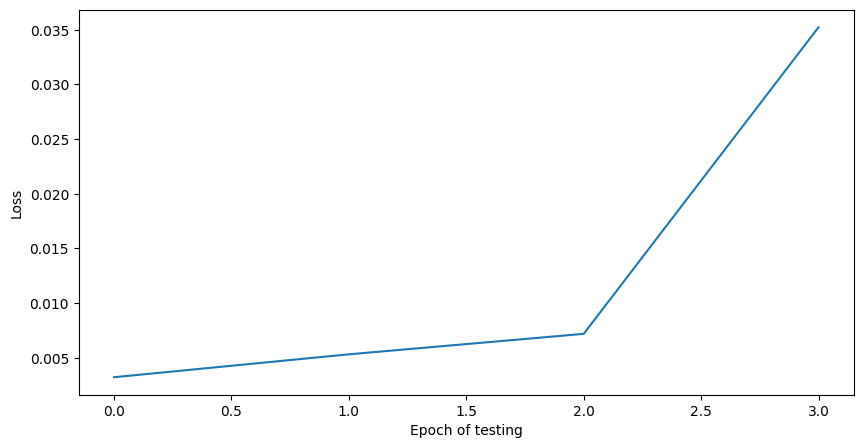

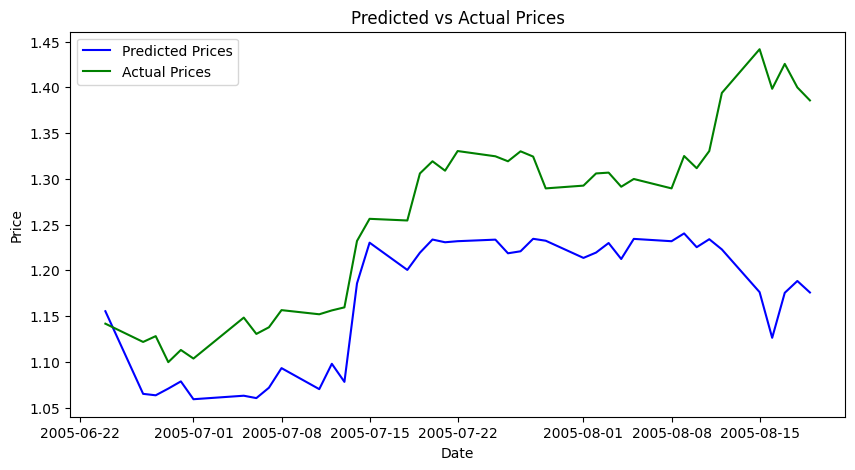

In [3]:
if BEST_MODEL_STATE_DICT:
    MODEL.load_state_dict(BEST_MODEL_STATE_DICT)

# Set to evaluation mode^
# MODEL^
MODEL.eval()
# Store the test loss for each epoch^
# TEST_LOSSES^
TEST_LOSSES = []


#PREDICTED_PRICES^
#ACTUAL_PRICES^
PREDICTED_PRICES = []
ACTUAL_PRICES = []


#DATE_LABELS^
DATE_LABELS = TESTING_DATA.index.tolist()
DATE_LABELS = DATE_LABELS[:40]

# Evaluate the model^
# TEST_DATASET^
# TEST_DATALOADER^
TEST_DATASET = StockPriceDataset(TESTING_DATA.head(40), TOKENIZER)
TEST_DATALOADER = DataLoader(TEST_DATASET, batch_size=10, shuffle=False)

with torch.no_grad():
    # BATCH_INDEX^
    # BATCH^
    for BATCH_INDEX, BATCH in enumerate(TEST_DATALOADER):
        # INPUT_IDS^
        # ATTENTION_MASK^
        INPUT_IDS = BATCH['input_ids']
        ATTENTION_MASK = BATCH['attention_mask']
        # LABELS^
        LABELS = BATCH['labels']
        # OUTPUTS^
        OUTPUTS = MODEL(input_ids = INPUT_IDS , attention_mask = ATTENTION_MASK)
        PREDICTED_PRICES.extend(OUTPUTS.squeeze(1).tolist())
        ACTUAL_PRICES.extend(LABELS.tolist())
        # LOSS^
        LOSS = CRITERION(OUTPUTS.squeeze(1), LABELS)
        TEST_LOSSES.append(LOSS.item())
# Plot the loss curve^
plt.figure(figsize=(10, 5))
plt.plot(TEST_LOSSES, label='Test Loss')
# Epoch of tesing^
plt.xlabel('Epoch of testing')
# Loss^
plt.ylabel('Loss')

plt.figure(figsize=(10, 5))
plt.plot(DATE_LABELS, PREDICTED_PRICES, label='Predicted Prices', color='blue')
plt.plot(DATE_LABELS, ACTUAL_PRICES, label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.show()

In [4]:
from sklearn.metrics import r2_score
import torch
#TEST_DATASET
TEST_DATASET = StockPriceDataset(TESTING_DATA, TOKENIZER)
#TEST_DATALOADER^
TEST_DATALOADER = DataLoader(TEST_DATASET, batch_size=32, shuffle=False)

#Switch to evaluation mode^
MODEL.eval()

#Store prediction^
#Store actuals^
PREDICTIONS = []
ACTUALS = []
with torch.no_grad():
    #BATCH^
    for BATCH in TEST_DATALOADER:
        #INPUT_IDS^
        INPUT_IDS = BATCH['input_ids']
        #ATTENTION_MASK^
        ATTENTION_MASK = BATCH['attention_mask']
        #LABELS^
        LABELS = BATCH['labels'].numpy() # Actual^
        
        #OUTPUT^
        OUTPUT = MODEL(input_ids = INPUT_IDS, attention_mask = ATTENTION_MASK)
        PREDICTION = OUTPUT.detach().numpy().flatten() # Prediction^
        PREDICTIONS.extend(PREDICTION)
        ACTUALS.extend(LABELS)
#Calculate R-square value^
r2 = r2_score(ACTUALS, PREDICTIONS)
print(f"R-squared: {r2}")

R-squared: -2.097051489951043
